Submitted by - Shivani Sharma

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# DATASET

## Utility Functions

In [11]:
def generate_image_pairs(images, labels):
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)


## Prepare Data


In [14]:
faces = 'olivetti_faces.npy'
faces_targets = 'olivetti_faces_target.npy'

In [15]:
# Loading Images
face_images = np.load(faces)
face_labels = np.load(faces_targets)

In [16]:
target_shape = face_images[0].shape

In [17]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

## Visualize

In [18]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

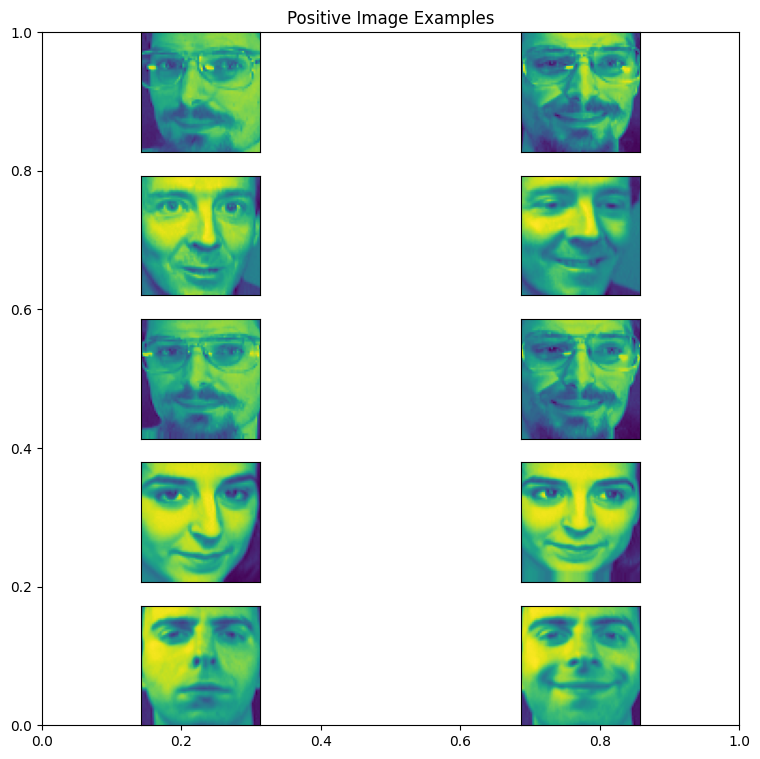

In [19]:
# Visualizing Positive Images

n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

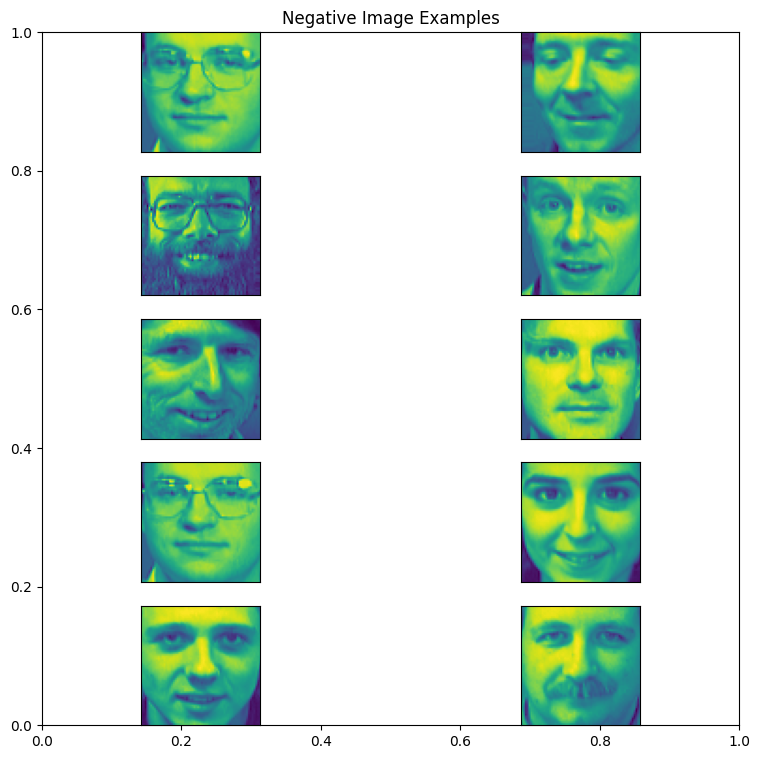

In [20]:
# Visualizing Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

# Network Architecture

## Embedding Layer

In [22]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

## Siamese Network

In [23]:
import tensorflow.keras.backend as K

In [33]:
# Define the Contrastive Loss
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [26]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))


In [27]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

## Training

In [28]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 [==============================] - 156s 16s/step - loss: 0.6999 - accuracy: 0.4906 - val_loss: 0.6935 - val_accuracy: 0.4625
Epoch 2/150
10/10 [==============================] - 145s 15s/step - loss: 0.6933 - accuracy: 0.4812 - val_loss: 0.6935 - val_accuracy: 0.4625
Epoch 3/150
10/10 [==============================] - 142s 14s/step - loss: 0.6932 - accuracy: 0.5125 - val_loss: 0.6935 - val_accuracy: 0.4625
Epoch 4/150
10/10 [==============================] - 172s 18s/step - loss: 0.6932 - accuracy: 0.5094 - val_loss: 0.6936 - val_accuracy: 0.4625
Epoch 5/150
10/10 [==============================] - 171s 17s/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6936 - val_accuracy: 0.4625
Epoch 6/150
10/10 [==============================] - 144s 15s/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6936 - val_accuracy: 0.4625
Epoch 7/150
10/10 [==============================] - 160s 16s/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6936 - val_accuracy: 0.4625

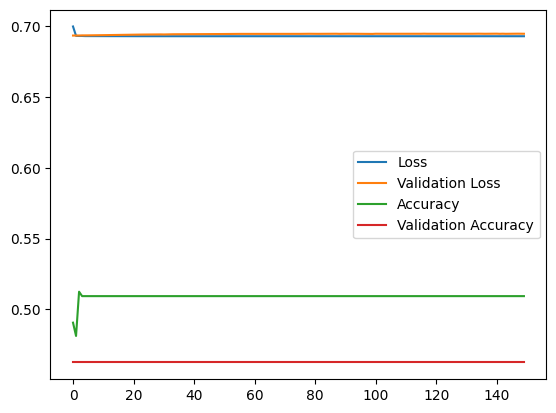

In [34]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])


# Testing

In [35]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

## Test 1

In [37]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

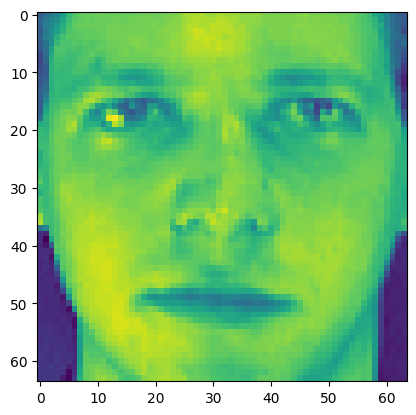

In [38]:
plt.imshow(test_image)

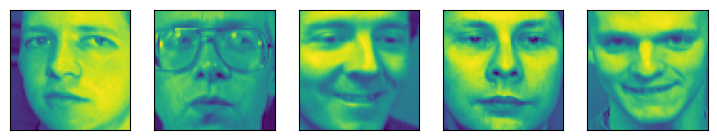

In [39]:
test_visualize(compare_images)

In [40]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [41]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 [==============================] - 1s 884ms/step


In [42]:
print(score)

[[0.49062306]
 [0.49062306]
 [0.49062306]
 [0.49062306]
 [0.49062306]]


## Test 2

In [43]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

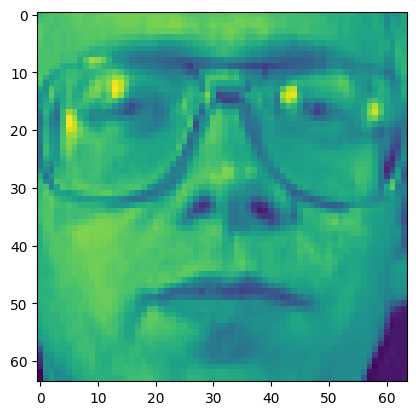

In [44]:
plt.imshow(test_image)

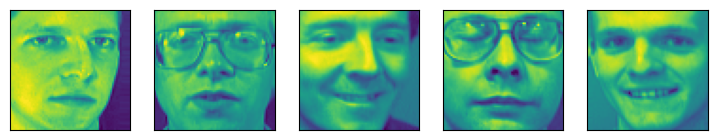

In [45]:
test_visualize(compare_images)

In [46]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [47]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 [==============================] - 1s 667ms/step


In [48]:
print(score)

[[0.49062306]
 [0.49062306]
 [0.49062306]
 [0.49062306]
 [0.49062306]]


In [53]:
def triplet_loss(y_true, y_pred, alpha=0.5):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

    # Calculating squared Euclidean distances
    pos_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

    # Calculating the triplet loss
    loss = tf.maximum(pos_distance - neg_distance + alpha, 0.0)

    return tf.reduce_mean(loss)

# Create example embeddings (replace with your actual embeddings)
anchor_embeddings = np.random.rand(100, 128)
positive_embeddings = np.random.rand(100, 128)
negative_embeddings = np.random.rand(100, 128)

# Create triplet labels (y_true) based on your dataset.

num_triplets = len(anchor_embeddings)
triplet_labels = np.zeros((num_triplets, 3))
triplet_labels[:, 0] = 1
triplet_labels[:, 1] = 1
triplet_labels[:, 2] = 0

# Calculate triplet loss separately for each element in y_pred
triplet_loss_anchor = triplet_loss(triplet_labels, anchor_embeddings, alpha=0.5)
triplet_loss_positive = triplet_loss(triplet_labels, positive_embeddings, alpha=0.5)
triplet_loss_negative = triplet_loss(triplet_labels, negative_embeddings, alpha=0.5)

# The triplet loss for the entire batch is the sum of individual triplet losses
triplet_loss_value = triplet_loss_anchor + triplet_loss_positive - triplet_loss_negative

# Use triplet_loss_value as the loss function when compiling your Siamese model.
print(triplet_loss_value)


tf.Tensor(3.999778339506973, shape=(), dtype=float64)
